In [1]:
import sys
sys.path.append('/global/homes/j/jpiat/shared_code/abacus_mocks/')


import numpy as np
from astropy.io import fits
from astropy.table import vstack,Table
import matplotlib.pyplot as plt
from hodpy.cosmology import CosmologyAbacus
from scipy.integrate import trapezoid as trap
from hodpy.k_correction import GAMA_KCorrection
from hodpy import lookup

cosmo = CosmologyAbacus(0)  #c000 cosmology
kcorr_r = GAMA_KCorrection(cosmo, k_corr_file=lookup.kcorr_file, cubic_interpolation=True)

In [2]:
path_in = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/'
file_cutsky = path_in+'cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006.fits'

sky = fits.open(file_cutsky)
data = sky[1].data
sky.close()
    
z = data['Z_COSMO']
M = data['R_MAG_ABS']
color = data['G_R_REST']

M = M - 0.8*(z-0.1)

KeyboardInterrupt: 

[0.5 0.4 0.3 0.2 0.1 0. ]
-22.811068392687552
-21.847311194603286
-20.890583515861973
-19.72629361727218
-17.934736359748893
[2.10286531 1.15383161 0.73225057 0.43403911 0.2045991 ]
effective s: 0.52582152011604


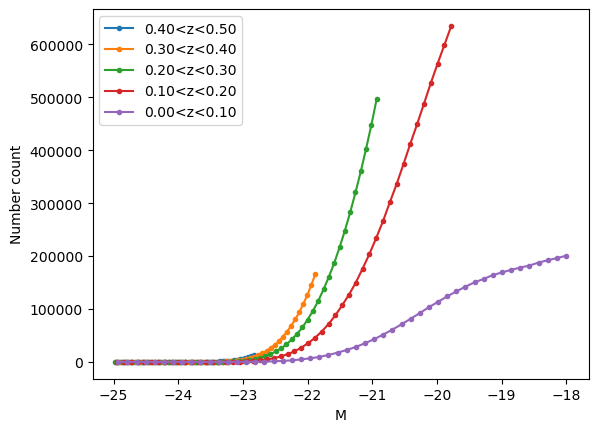

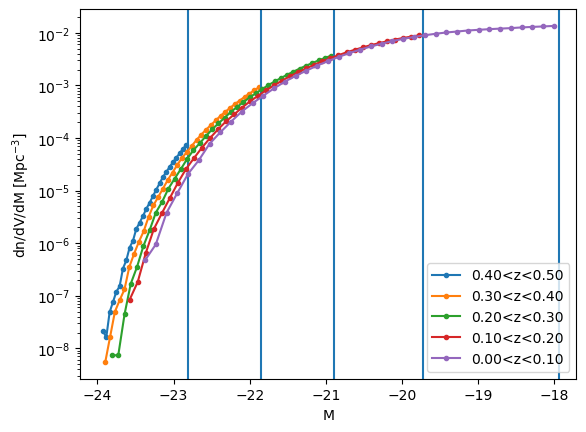

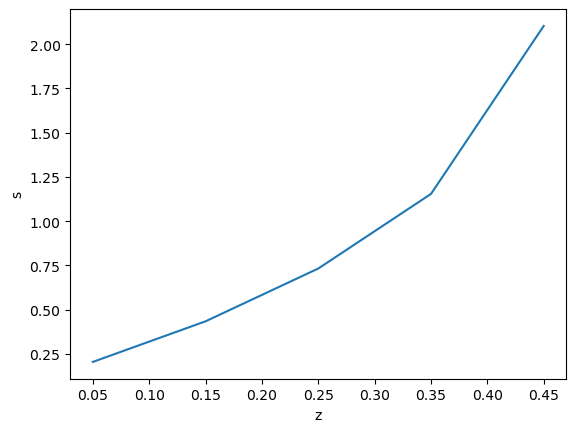

In [3]:
znbins = 5
zbins = np.linspace(0.5,0.,znbins+1)
zc = 0.5*(zbins[1:]+zbins[:-1])

print(zbins)

n1 = np.zeros(znbins)
n2 = np.zeros(znbins)
s = np.zeros(znbins)
s_eff = 0
N_tot = 0

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()


for i in range(znbins):
    
    Mi = M[(z<zbins[i])&(z>=zbins[i+1])]
    colori = color[(z<zbins[i])&(z>=zbins[i+1])]
    
    M_lim = kcorr_r.absolute_magnitude(19.5,np.array([zbins[i]]),np.array([np.max(colori)]))[0]
    print(M_lim)
    
    N = len(Mi[Mi<=M_lim])
    
    Mbins = np.linspace(-25., M_lim, 51)
    dM = Mbins[1]-Mbins[0]
    Mc = 0.5*(Mbins[1:]+Mbins[:-1])
    
    d1 = cosmo.comoving_distance(zbins[i+1])
    d2 = cosmo.comoving_distance(zbins[i])
    vol = 4/3*np.pi*(d2**3-d1**3)
    
    Nc = np.histogram(Mi,bins=Mbins)[0]
    LF = Nc/vol/dM
    
    valid = LF > 0
    
    n2[i] = trap(LF,Mc)
    
    s[i] = LF[-1]/n2[i]/np.log(10)
    
    s_eff += s[i]*N
    N_tot += N
    
    ax1.plot(Mc, Nc, marker = '.', label = '{0:.2f}<z<{1:.2f}'.format(zbins[i+1],zbins[i]))
    ax1.set_xlabel('M')
    ax1.set_ylabel('Number count')
    ax1.legend()
    
    ax2.plot(Mc[valid], LF[valid], marker = '.', label = '{0:.2f}<z<{1:.2f}'.format(zbins[i+1],zbins[i]))
    ax2.set_xlabel('M')
    ax2.set_ylabel('dn/dV/dM [Mpc$^{-3}$]')
    ax2.set_yscale('log')
    ax2.axvline(M_lim)
    ax2.legend()
    
#plt.figure()
#plt.xlabel('z')
#plt.ylabel('comoving number density')
#plt.plot(zc, n1)
#plt.plot(zc, n2,'--')

plt.figure()
plt.xlabel('z')
plt.ylabel('s')
plt.plot(zc, s)

print(s)
print('effective s:', s_eff/N_tot)

s from apparent magnitudes: 0.4269886194414134


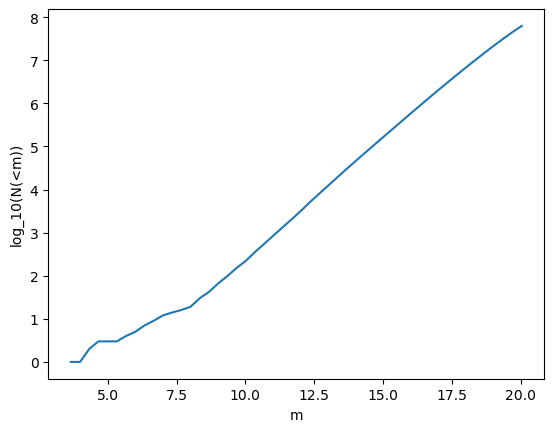

In [4]:
m = data['R_MAG_APP']
m = m[z<=0.5]

h, bins = np.histogram(m,50)
mc = 0.5*(bins[1:]+bins[:-1])
ch = np.cumsum(h)

plt.figure()
plt.plot(mc,np.log10(ch))
plt.ylabel('log_10(N(<m))')
plt.xlabel('m')

s_app = (np.log10(ch[-1])-np.log10(ch[-2]))/(mc[-1]-mc[-2])
print('s from apparent magnitudes:', s_app)